cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader
from functions_cae import CAEWithPooling, SimpleCAE, DeepCAE, validate_cae, train_autoencoder, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, MLP

In [2]:
##### CONFIG
NUM_EPOCHS = 5
LR_RATE = 1e-4
BATCH_SIZE = 4
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
OBJECTS = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk', '12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher', '16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [12]:
# train_loader_color = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
# val_loader_color = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
# test_loader_color = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

In [3]:
train_loader_depth = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "depthcolormap", "training", batch_size=BATCH_SIZE)
val_loader_depth = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "depthcolormap", "validation", batch_size=BATCH_SIZE)
test_loader_depth = get_loader(BASE_PATH, OBJECTS, TOOL_NAMES, ACTIONS, "depthcolormap", "testing", batch_size=BATCH_SIZE)

Epoch [1/5], Loss: 0.3879, PSNR: 14.2407


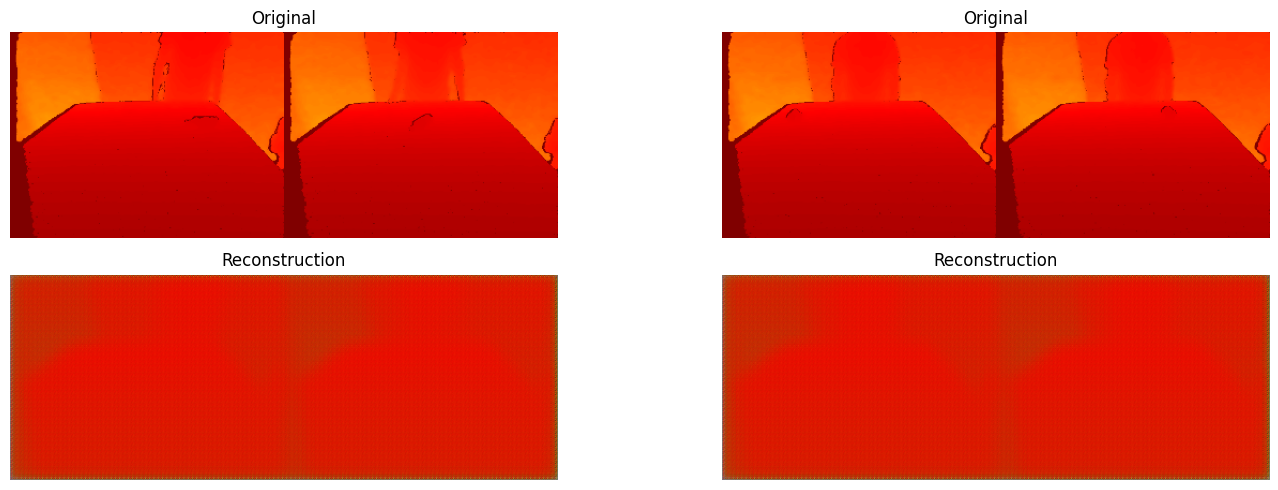

Epoch [2/5], Loss: 0.2341, PSNR: 19.7027


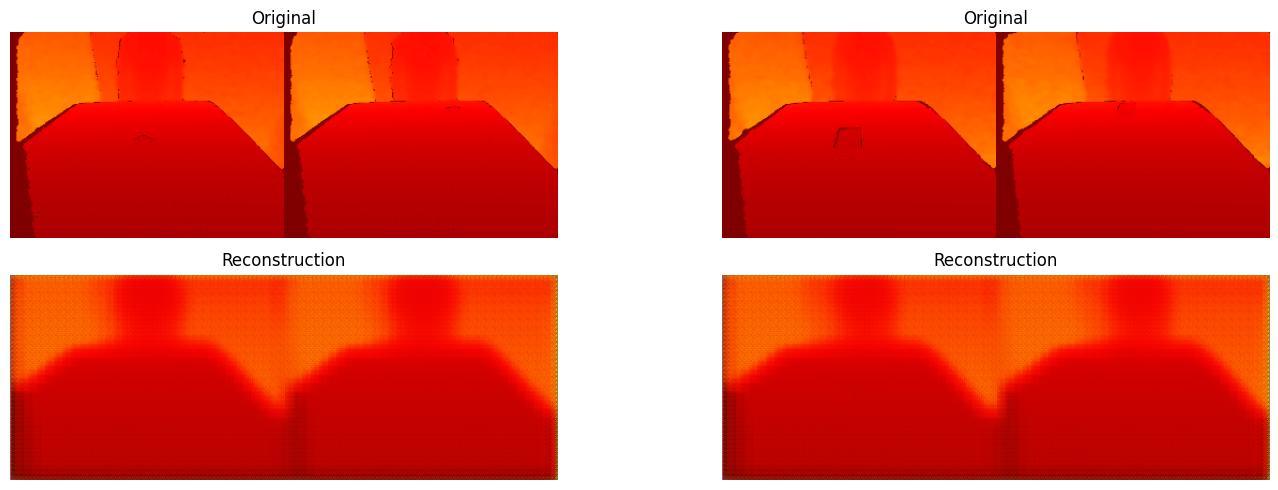

Epoch [3/5], Loss: 0.1924, PSNR: 25.4001


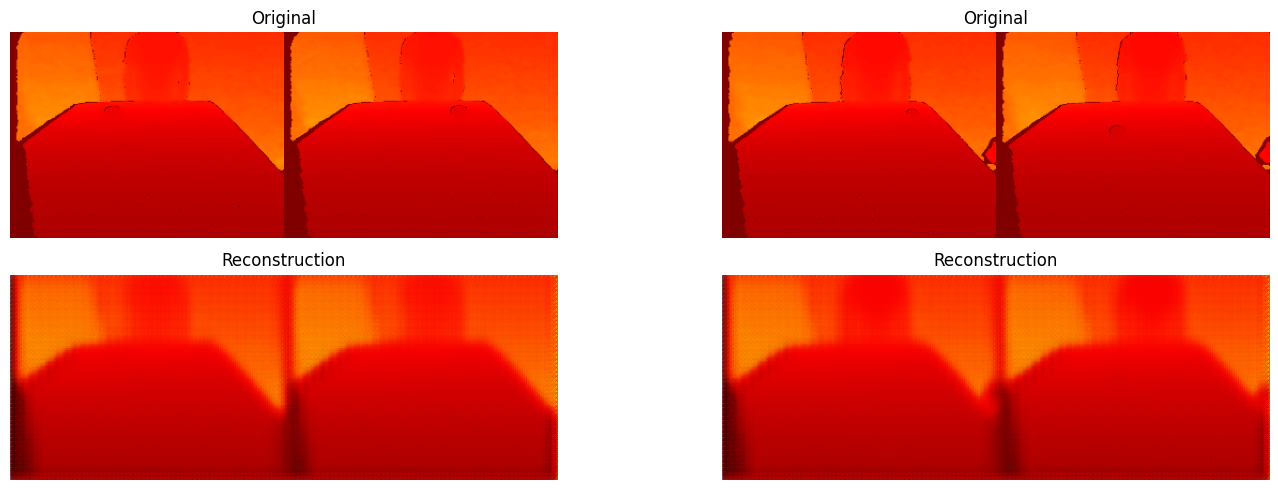

Epoch [4/5], Loss: 0.1855, PSNR: 27.7089


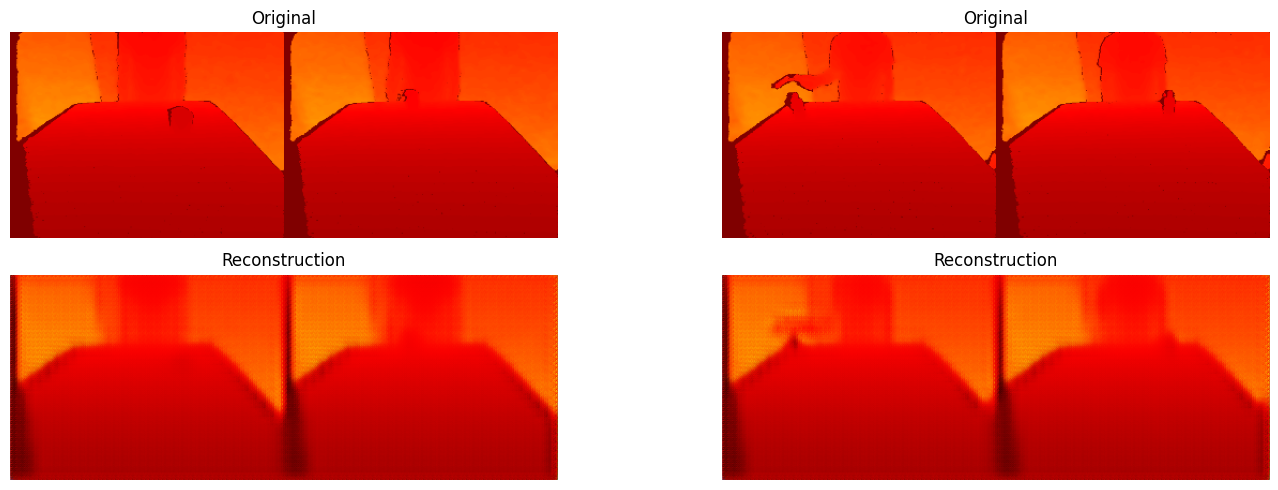

Epoch [5/5], Loss: 0.1832, PSNR: 29.1676


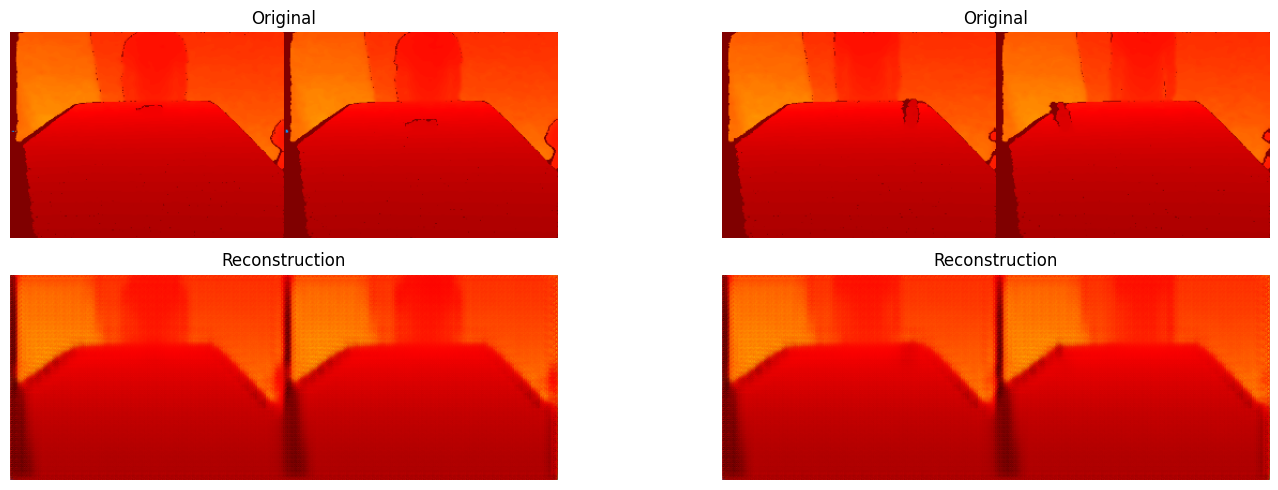

Average Validation Loss: 0.1824705997481942
Average PSNR: 29.725601978186035


In [4]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE(input_channels=3).to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
#cae = DeepCAE().to(DEVICE)
# For depth images
cae = CAEWithPooling(input_channels=3).to(DEVICE)

# For color images
#cae = DeepCAE(input_channels=3).to(DEVICE)  # This is equivalent to your original setup

cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_epoch_loss_history = train_autoencoder(cae, train_loader_depth, cae_lossfunction, cae_optimizer_adam, is_depth=False, num_epochs=NUM_EPOCHS, add_noise=False, device=DEVICE, visualize=True)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, val_loader_depth, cae_lossfunction, is_depth=False, device=DEVICE)

In [ ]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne10_b4_depth.pth"
torch.save(trained_cae.state_dict(), model_path)

In [ ]:
model_path = "C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/weights/deepcae_ne10_b4_depth.pth"
trained_cae = DeepCAE(input_channels=1)
trained_cae.load_state_dict(torch.load(model_path))

<All keys matched successfully>

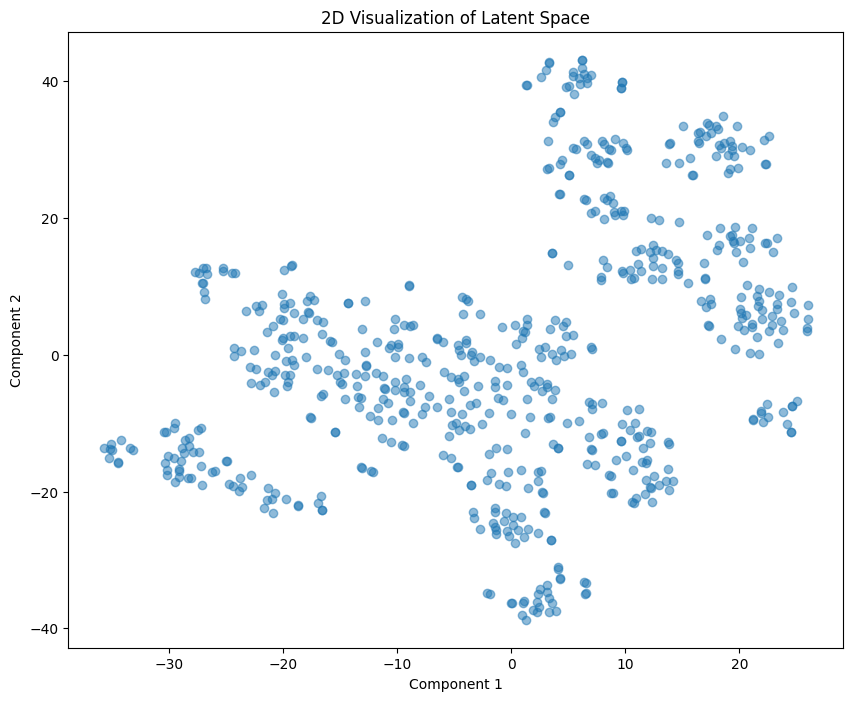

In [17]:
visualize_latent_space(trained_cae, val_loader_depth, is_depth=False, n_components=2, random_state=42)

In [18]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5
LR_RATE = 1e-3
BATCH_SIZE = 4

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, val_loader_depth, label=1, add_noise=False, is_depth=False, device=DEVICE)
val_dataset = get_latent_dataset(trained_cae, test_loader_depth, label=1, add_noise=False, is_depth=False, device=DEVICE)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = MLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
#validate_mlp(trained_mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5],  Train Loss: 16.3661, Train Acc: 0.2281,  Train Precision: 0.2269, Train Recall: 0.2281,  Train F1: 0.2270


c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/5],  Train Loss: 1.3874, Train Acc: 0.2266,  Train Precision: 0.1069, Train Recall: 0.2266,  Train F1: 0.1288


c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/5],  Train Loss: 1.3873, Train Acc: 0.2422,  Train Precision: 0.0968, Train Recall: 0.2422,  Train F1: 0.1109


c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/5],  Train Loss: 1.3871, Train Acc: 0.2328,  Train Precision: 0.1573, Train Recall: 0.2328,  Train F1: 0.1525
Epoch [5/5],  Train Loss: 1.3870, Train Acc: 0.2234,  Train Precision: 0.1577, Train Recall: 0.2234,  Train F1: 0.1759


c:\Users\Frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_image(image_path, depth=False):
    """ Load an image using OpenCV. """
    if depth:
        return cv2.imread(image_path, cv2.IMREAD_ANYDEPTH)  # Load depth image
    else:
        return cv2.imread(image_path) 
    
def display_image(image, title="Image"):
    """ Display an image using Matplotlib. """
    if len(image.shape) == 2:  # Grayscale or depth image
        plt.imshow(image,)
    else:  # Color image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
width, height = 256, 192
base_path = 'C:/Users/Frank/OneDrive/Bureaublad/action_recognition_dataset/'
color1 = 'C:/Users/Frank/OneDrive/Bureaublad/action_recognition_dataset/0_woodenCube/hook/left_to_right/color/effect_color_0.png'
depth1 = 'C:/Users/Frank/OneDrive/Bureaublad/action_recognition_dataset/0_woodenCube/hook/left_to_right/depthcolormap/effect_depthcolormap_9.png'

In [ ]:
depth_image = load_image(depth1, depth=True)
#depth_img = cv2.equalizeHist(depth_img)
#_, depth_img = cv2.threshold(depth_img, thresh=50, maxval=255, type=cv2.THRESH_BINARY)
#depth_img = cv2.Canny(depth_img, threshold1=100, threshold2=200)
# kernel = np.ones((10, 10), np.uint8)
# depth_img = cv2.morphologyEx(depth_img, cv2.MORPH_CLOSE, kernel)
depth_image = cv2.applyColorMap(depth_image, cv2.COLORMAP_JET)

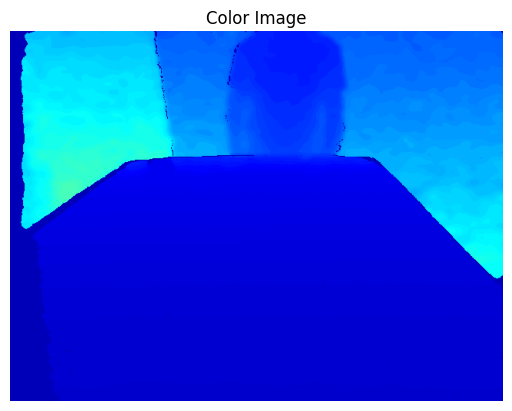

In [ ]:
display_image(depth_image, "Color Image")